# Speech to Speech Flow

## Speech to Text
Objectives:
1. Transcribe text
2. Preserve timestamp

In [63]:
from pathlib import Path
import pytube as pt
from openai import OpenAI
import os
from dotenv import load_dotenv

dotenv_path = Path("__file__").resolve().parents[1].parents[0] / '.local.env'
load_dotenv(dotenv_path)

OpenAI.api_key = os.getenv("OPENAI_API_KEY")
data_path = Path("__file__").resolve().parents[1].parents[0] / "local_data"

In [64]:
YOUTUBE_VIDEO_URL = "https://www.youtube.com/watch?v=uTw-XjaWFTg"

In [65]:
yt = pt.YouTube(YOUTUBE_VIDEO_URL)
stream = yt.streams.filter(only_audio=True, use_oauth = True, allow_oauth_cache=True, )[0]
audio_file_path = Path(data_path) / "rakugo_v1.mp3"
stream.download(filename=audio_file_path)

AgeRestrictedError: uTw-XjaWFTg is age restricted, and can't be accessed without logging in.

In [28]:
# from pydub import AudioSegment
# audio = AudioSegment.from_file(audio_file_path)
# two_minutes = 120 * 1000

# audio = audio[:two_minutes]
# shortened_audio_file_path = Path(data_path) / "rakugo_v1_short.mp3"
# audio.export(shortened_audio_file_path, format="mp3")

In [29]:
client = OpenAI()

shortened_audio_file_path = Path(data_path) / "rakugo_v1_short.mp3"
audio_file= open(audio_file_path, "rb")

transcript = client.audio.transcriptions.create(
  file=audio_file_path,
  model="whisper-1",
  response_format="verbose_json",
  timestamp_granularities=["word"]
)

In [30]:
transcript.words[:10]

[{'word': 'me', 'start': 15.539999961853027, 'end': 15.880000114440918},
 {'word': 'a', 'start': 15.880000114440918, 'end': 11.319999694824219},
 {'word': '練', 'start': 16.219999313354492, 'end': 17.059999465942383},
 {'word': '習', 'start': 17.059999465942383, 'end': 17.200000762939453},
 {'word': 'した', 'start': 17.200000762939453, 'end': 17.420000076293945},
 {'word': 'よう', 'start': 17.420000076293945, 'end': 17.520000457763672},
 {'word': 'な', 'start': 17.520000457763672, 'end': 17.65999984741211},
 {'word': '小', 'start': 17.65999984741211, 'end': 17.799999237060547},
 {'word': '刻', 'start': 17.799999237060547, 'end': 17.899999618530273},
 {'word': 'み', 'start': 17.899999618530273, 'end': 18.059999465942383}]

In [31]:
# find the possible pause time between words (top 10% of pause times)
pause_times = []
for i in range(len(transcript.words) - 1):
    pause_times.append(transcript.words[i+1]["start"] - transcript.words[i]["end"])

# find the top 10% of pause times
pause_times.sort()
top_20_pause_times = pause_times[-int(len(pause_times) * 0.05):]
average_pause_time = sum(top_20_pause_times) / len(top_20_pause_times)
print(average_pause_time)

0.48859426379203796


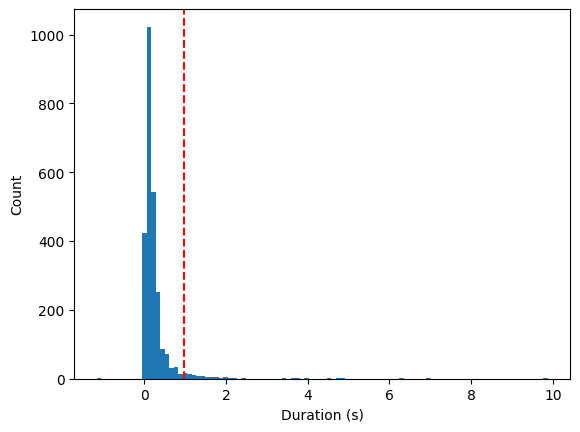

In [37]:
# visulaize the time between words, present the cut-off point
import matplotlib.pyplot as plt
import numpy as np

timestamps = [word["start"] for word in transcript.words]
durations = np.diff(timestamps)
plt.hist(durations, bins=100)
plt.axvline(2*average_pause_time, color="red", linestyle="--")
plt.xlabel("Duration (s)")
plt.ylabel("Count")
plt.show()

In [38]:
# group words into sentences (based on timestamps)
# or if end in "ます" or "です"　but not "ですよ"
sentences = []
sentence = ""
timestamps_start = []
timestamps_end = []
for word in transcript.words:
    if sentence == "":
        timestamps_start.append(word["start"])
    sentence += word["word"]
    if word["end"] - word["start"] > average_pause_time*2 or word["word"][-2:] in ["ます", "です"]:
        sentences.append(sentence)
        sentence = ""
        timestamps_end.append(word["end"])

print(len(sentences), "sentences found")
print(sentences[:5])
print(timestamps_start[:5])
print(timestamps_end[:5])

81 sentences found
['mea練習したような小刻みの白松がございます', '春風て一ノ助と申しましてま嘘つきは泥棒の始まりなんとま', 'あねほんと猫立ちの悪い嘘つくよりはちょいと間抜けな泥棒のほうが買い代わりようでございます', 'おしまいしまいこっち来いしまいはい親分なんかご用ですかよですかじゃないよねおめのこと仲間がなぁなんて言ってか知ってんのかねあら見込みがねからさっさと足荒らして敵に戻したらどうだってみんな濡れるとのこと言ってんだよねどうするよ泥棒やめるか足洗うかあのって言ってんすか自分でもまあ土地ばかり踏んでんなってのはよくわかってんです', 'かねこれから魔法炉に立ち帰った悪事に励みます']
[15.539999961853027, 20.579999923706055, 26.299999237060547, 32.2400016784668, 52.47999954223633]
[19.68000030517578, 26.299999237060547, 32.2400016784668, 52.47999954223633, 56.36000061035156]


## Text to text
Objectives
1. Easify the text
2. Try to preserve the length of text

In [39]:
# join sentences in the format of
# 1. sentence1
# 2. sentence2
# ...
input_text = "\n".join([f"{i+1}. {sentence}" for i, sentence in enumerate(sentences)])
print(input_text)
JLPT_LEVEL = "N4"

1. mea練習したような小刻みの白松がございます
2. 春風て一ノ助と申しましてま嘘つきは泥棒の始まりなんとま
3. あねほんと猫立ちの悪い嘘つくよりはちょいと間抜けな泥棒のほうが買い代わりようでございます
4. おしまいしまいこっち来いしまいはい親分なんかご用ですかよですかじゃないよねおめのこと仲間がなぁなんて言ってか知ってんのかねあら見込みがねからさっさと足荒らして敵に戻したらどうだってみんな濡れるとのこと言ってんだよねどうするよ泥棒やめるか足洗うかあのって言ってんすか自分でもまあ土地ばかり踏んでんなってのはよくわかってんです
5. かねこれから魔法炉に立ち帰った悪事に励みます
6. から今までより置いちゃってくださいこの通りで言ってることおかしいんだおめ今日はなぁ俺はおめのこと仕事連れて行っちゃうから目で見て覚えろ目で見て悪がああよろしくお願いします
7. 勉強させていただきます
8. 試作しな試作しななんすかしたくって蝶になすずりと筆が出るんだろう誰だかわかんねーように顔に髭を書くのが泥棒の一番のしたくらうん顔
9. に髭を書くそ
10. んならそっと早く言ってあちらてまんざらバカじゃないんです
11. よ馬鹿だよお前ははいやれやすすかへこれでねこれで髭ねお会いした体裁のいい日がねいいですね揉み上げだそれ髭だよ分かってつく剪索家庭です
12. からねですか
13. そんな偉そうな髭じゃなくていいんだよなぞ大久保としみつめしげしちゃっ明日どっちかというとあのクラーク博士を意識してどっちでもいいんだバー花の下真っ黒いのが泥棒の姿がわかるあああああ見たことあるねそんならそうだ早く言って足立てまんざら馬鹿じゃない馬鹿なんだ早くやるよこれでねここでいいですかそれでいいやどす持ってくれどすなんかどうそそにあんたら刃物が空どうすだこれはどうするですかあそうですかこれなんどうすああこれなんでどうすってんすか
14. どうでもいいようなことはこれは何でどうすってんすか教えてください親分ドットさしてスッと抜かれどうすればいいそう
15. なんですかじゃあこれスッと刺してドット抜いたらスドですかこれずっと刺してバッドにはズバですかビットさ何でもいいんだバカやる飲んどけ飲んどけ飲むこれを
16. あのオブラートあります
17. かあれば飲めんのがこのやる懐にしまうの飲むって言うん

In [47]:
completion = client.chat.completions.create(
  model="gpt-4",
  messages=[
    {"role": "system", "content": """
    日本の落語の一節と日本語能力試験（JLPT）のレベルが与えられます。\n
    その節を、一文ずつ、指定されたJLPTレベルに適した語彙や文法を使って変更してください。\n
    文の数は変更しないでください。\n
     """},
    {"role": "user", "content": f"""
    JLPTレベル: {JLPT_LEVEL}\n
     落語の節:\n
     {input_text}
     """}
  ]
)


In [48]:
completion.choices[0].message

ChatCompletionMessage(content='JLPTレベル: N4\n\n落語の節を簡易化:\n\n1. 綺麗に練習した白松があります。\n2. 私、春風という者なんですが、嘘つきは盗人になると言いますね。\n3. でも、ちょっとバカな盗人の方が魅力的だと思います。\n4. いいえ、いいえ、こっちは仲間です。足元が悪いなら、早く直して、良い道に戻れば？泥棒をやめるか、足元を直すか、どうしますか？\n5. これからは悪行を再開しようと思います。\n6. だからこれからも、私の言葉を信じてください。私はあなたを導きますので、良く見て覚えてくださいね。\n7. 勉強させていただきます。\n8. 試行錯誤して、筆と紙を持って、顔に髭を描くのが盗人の最も必要な準備です。\n9. そう、髭を描くんです。\n10. それなら最初から教えてください。私はそれほどバカではないはずです。\n11. はい、確かに、あなたはバカですね。でも、この髭は魅力的ですね。ああ、なるほど、これは髭ですね。私は理解しました。\n12. ねえ、それはどうしたの？\n13. シンプルな髭でもいいんですよ。クラーク博士の顔を真似てみてください。どちらでもいいと思いますが、盗人のいい格好は真っ黒だと言います。\n14. うーん、どうしますか？逃げるか泥棒をやめるか？\n15. これはどう使いますか？教えてください、親分。剣はどう抜くのですか？\n16. オブラートはありますか？\n17. あれば飲むのがこの剣です。飲むとは、懐にしまうことを意味します。\n18. じゃあ、さっさと行きましょう。夜道が危険なので、我々泥棒が行かなければなりません。\n19. 我々はどこに行くのですか？鈴川に行くのですか？\n20. ええ、そこは危険な場所ですね。\n21. そうですね、その場所は暗くて、怖い声がする。\n22. やぶの中に隠れて、旅人を観察します。旅人が来たら、すぐに出ていかないで、わざと遅らせてから声をかけます。覚えておいてください。\n23. 旅人はたくさんいます。彼らが私たちの縄張りを知って渡るかどうかで、我々の対応が変わります。知って渡ったなら、命は無い。知らずに渡ったなら、命は助けてやります。ただし、その代わりに財布を取らせてもらいます。\n24. はっはっは。\n25. 理解した、理

In [49]:
completion_output = completion.choices[0].message.content
print(completion_output)

JLPTレベル: N4

落語の節を簡易化:

1. 綺麗に練習した白松があります。
2. 私、春風という者なんですが、嘘つきは盗人になると言いますね。
3. でも、ちょっとバカな盗人の方が魅力的だと思います。
4. いいえ、いいえ、こっちは仲間です。足元が悪いなら、早く直して、良い道に戻れば？泥棒をやめるか、足元を直すか、どうしますか？
5. これからは悪行を再開しようと思います。
6. だからこれからも、私の言葉を信じてください。私はあなたを導きますので、良く見て覚えてくださいね。
7. 勉強させていただきます。
8. 試行錯誤して、筆と紙を持って、顔に髭を描くのが盗人の最も必要な準備です。
9. そう、髭を描くんです。
10. それなら最初から教えてください。私はそれほどバカではないはずです。
11. はい、確かに、あなたはバカですね。でも、この髭は魅力的ですね。ああ、なるほど、これは髭ですね。私は理解しました。
12. ねえ、それはどうしたの？
13. シンプルな髭でもいいんですよ。クラーク博士の顔を真似てみてください。どちらでもいいと思いますが、盗人のいい格好は真っ黒だと言います。
14. うーん、どうしますか？逃げるか泥棒をやめるか？
15. これはどう使いますか？教えてください、親分。剣はどう抜くのですか？
16. オブラートはありますか？
17. あれば飲むのがこの剣です。飲むとは、懐にしまうことを意味します。
18. じゃあ、さっさと行きましょう。夜道が危険なので、我々泥棒が行かなければなりません。
19. 我々はどこに行くのですか？鈴川に行くのですか？
20. ええ、そこは危険な場所ですね。
21. そうですね、その場所は暗くて、怖い声がする。
22. やぶの中に隠れて、旅人を観察します。旅人が来たら、すぐに出ていかないで、わざと遅らせてから声をかけます。覚えておいてください。
23. 旅人はたくさんいます。彼らが私たちの縄張りを知って渡るかどうかで、我々の対応が変わります。知って渡ったなら、命は無い。知らずに渡ったなら、命は助けてやります。ただし、その代わりに財布を取らせてもらいます。
24. はっはっは。
25. 理解した、理解していないだろうけどね。
26. 私が真似するのは無理です、親分は上手すぎる。役者のように。
27. そんな長い台詞

In [50]:
# save the easified text using regex
# "number". "sentence" -> "sentence"
import re

easified_sentences = re.findall(r"\d+\. (.+)", completion_output)
print(len(easified_sentences), " sentences found from ", len(sentences), " sentences")
print(easified_sentences)

81  sentences found from  81  sentences
['綺麗に練習した白松があります。', '私、春風という者なんですが、嘘つきは盗人になると言いますね。', 'でも、ちょっとバカな盗人の方が魅力的だと思います。', 'いいえ、いいえ、こっちは仲間です。足元が悪いなら、早く直して、良い道に戻れば？泥棒をやめるか、足元を直すか、どうしますか？', 'これからは悪行を再開しようと思います。', 'だからこれからも、私の言葉を信じてください。私はあなたを導きますので、良く見て覚えてくださいね。', '勉強させていただきます。', '試行錯誤して、筆と紙を持って、顔に髭を描くのが盗人の最も必要な準備です。', 'そう、髭を描くんです。', 'それなら最初から教えてください。私はそれほどバカではないはずです。', 'はい、確かに、あなたはバカですね。でも、この髭は魅力的ですね。ああ、なるほど、これは髭ですね。私は理解しました。', 'ねえ、それはどうしたの？', 'シンプルな髭でもいいんですよ。クラーク博士の顔を真似てみてください。どちらでもいいと思いますが、盗人のいい格好は真っ黒だと言います。', 'うーん、どうしますか？逃げるか泥棒をやめるか？', 'これはどう使いますか？教えてください、親分。剣はどう抜くのですか？', 'オブラートはありますか？', 'あれば飲むのがこの剣です。飲むとは、懐にしまうことを意味します。', 'じゃあ、さっさと行きましょう。夜道が危険なので、我々泥棒が行かなければなりません。', '我々はどこに行くのですか？鈴川に行くのですか？', 'ええ、そこは危険な場所ですね。', 'そうですね、その場所は暗くて、怖い声がする。', 'やぶの中に隠れて、旅人を観察します。旅人が来たら、すぐに出ていかないで、わざと遅らせてから声をかけます。覚えておいてください。', '旅人はたくさんいます。彼らが私たちの縄張りを知って渡るかどうかで、我々の対応が変わります。知って渡ったなら、命は無い。知らずに渡ったなら、命は助けてやります。ただし、その代わりに財布を取らせてもらいます。', 'はっはっは。', '理解した、理解していないだろうけどね。', '私が真似するのは無理です、親分は上手すぎる。役者のように。', 'そんな長い台詞は覚え

## Text to speech
Objectives
1. Synchronise with timestamps
2. Use same voice

In [51]:
speech_file_path = Path(data_path) / "speech_v1.mp3"

In [52]:
response = client.audio.speech.create(
  model="tts-1",
  voice="onyx",
  input=f"{easified_sentences[0]}"
)
type(response)

openai._legacy_response.HttpxBinaryResponseContent

In [113]:
response.stream_to_file(speech_file_path)

/var/folders/sy/4mvdh7yx2rn37237j7qbqrdr0000gn/T/ipykernel_8522/2952188555.py:1: DeprecationWarning: Due to a bug, this method doesn't actually stream the response content, `.with_streaming_response.method()` should be used instead
  response.stream_to_file(speech_file_path)
